In [40]:
from typing import Callable, Iterator, Sequence, Tuple
import functools

import numpy as np
import scipy as sp
import matplotlib.pylab as plt

import jax.numpy as jnp
import jax.scipy as jsp
from jax import random, jit, grad, value_and_grad
from flax.training import train_state
import tensorflow_probability.substrates.jax as tfp


from sklearn.metrics import mean_squared_error
import jax
import flax.linen as nn
import optax
import haiku as hk
import chex
import tqdm

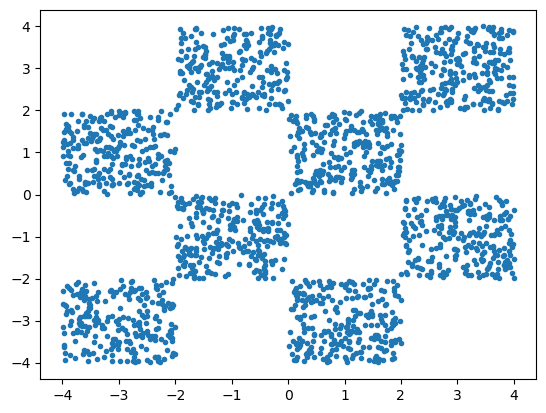

In [15]:
def generate_checkerboard(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/malbergo/stochastic-interpolants/blob/main/notebooks/checker-mirror.ipynb
    x1 = rng.uniform(size=num) * 4 - 2
    x2_ = rng.uniform(size=num) - rng.choice([0, 1], size=(num,)) * 2
    x2 = x2_ + (np.floor(x1) % 2)
    x = np.hstack([x1[:, None], x2[:, None]]) * 2
    return x

X_train = generate_checkerboard(num=2000, rng=np.random.default_rng())
plt.plot(X_train[:, 0], X_train[:, 1], '.')

In [28]:
class Encoder(nn.Module):
    bottleneck: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.selu(x)
        x = nn.Dense(features=self.bottleneck)(x)
        return x

class Decoder(nn.Module):
    out: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.selu(x)
        x = nn.Dense(features=self.out)(x)
        return x

In [29]:
model_enc = Encoder(1)
params_enc = model_enc.init(random.PRNGKey(0), X_train)
X_bottlenecked = model_enc.apply(params_enc, X_train)
print(model_enc.tabulate(random.PRNGKey(0), X_train))



                                Encoder Summary                                 
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs          ┃ outputs         ┃ params               ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Encoder │ float32[2000,2] │ float32[2000,1] │                      │
├─────────┼─────────┼─────────────────┼─────────────────┼──────────────────────┤
│ Dense_0 │ Dense   │ float32[2000,2] │ float32[2000,5] │ bias: float32[5]     │
│         │         │                 │                 │ kernel: float32[2,5] │
│         │         │                 │                 │                      │
│         │         │                 │                 │ 15 (60 B)            │
├─────────┼─────────┼─────────────────┼─────────────────┼──────────────────────┤
│ Dense_1 │ Dense   │ float32[2000,5] │ float32[2000,1] │ bias: float32[1]     │
│         │         │      

In [30]:
model_dec = Decoder(out=2)
print(model_dec.tabulate(random.PRNGKey(0), X_bottlenecked))



                                Decoder Summary                                 
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs          ┃ outputs         ┃ params               ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Decoder │ float32[2000,1] │ float32[2000,2] │                      │
├─────────┼─────────┼─────────────────┼─────────────────┼──────────────────────┤
│ Dense_0 │ Dense   │ float32[2000,1] │ float32[2000,5] │ bias: float32[5]     │
│         │         │                 │                 │ kernel: float32[1,5] │
│         │         │                 │                 │                      │
│         │         │                 │                 │ 10 (40 B)            │
├─────────┼─────────┼─────────────────┼─────────────────┼──────────────────────┤
│ Dense_1 │ Dense   │ float32[2000,5] │ float32[2000,2] │ bias: float32[2]     │
│         │         │      

In [33]:
class VAE_Encoder(nn.Module):
    bottleneck: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.selu(x)
        mu = nn.Dense(features=self.bottleneck)(x)
        log_std = nn.Dense(features=self.bottleneck)(x)
        return mu, log_std
def reparameterize(mu, log_std, key=random.PRNGKey(0), samples=1):
    std = jnp.exp(log_std)
    eps = random.normal(key=key, shape=(samples,))
    return mu + eps * std

In [34]:
class VAE(nn.Module):
    bottleneck: int
    out: int

    def setup(self):
        # Alternative to @nn.compact -> explicitly define modules
        # Better for later when we want to access the encoder and decoder explicitly
        self.encoder = VAE_Encoder(bottleneck=self.bottleneck)
        self.decoder = Decoder(out=self.out)

    def __call__(self, x, rng=random.PRNGKey(0)):
        mu, log_std = self.encoder(x)
        z = reparameterize(mu, log_std, key=rng)
        x_hat = self.decoder(z)
        return x_hat, mu, log_std

In [41]:
def vae_loss(x, x_hat, mu, log_std):
    # MSE as reconstruction loss
    reconstruction_loss = jnp.mean((x - x_hat) ** 2)
    
    # KL divergence
    kl_divergence = -0.5 * jnp.sum(1 + 2 * log_std - jnp.square(mu) - jnp.exp(2 * log_std))
    
    return reconstruction_loss + kl_divergence


In [42]:
bottleneck_dim = 10
output_dim = X_train.shape[1]  # 假设输出维度与输入维度相同

# 初始化模型
vae_model = VAE(bottleneck=bottleneck_dim, out=output_dim)
params = vae_model.init(jax.random.PRNGKey(0), X_train[0:1], jax.random.PRNGKey(0))  # 使用一个样本进行初始化

# 定义优化器
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)

In [43]:
@jax.jit
def train_step(params, opt_state, batch, rng):
    # 计算损失函数和梯度
    def loss_fn(params):
        x_hat, mu, log_std = vae_model.apply(params, batch, rng)
        return vae_loss(batch, x_hat, mu, log_std)

    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss


In [44]:
num_epochs = 10
batch_size = 64
num_batches = X_train.shape[0] // batch_size

losses = []
for epoch in range(num_epochs):
    for i in range(num_batches):
        batch = X_train[i * batch_size:(i + 1) * batch_size]
        rng, iter_rng = jax.random.split(rng)
        params, opt_state, loss = train_step(params, opt_state, batch, iter_rng)
        losses.append(loss)
    print(f'Epoch {epoch}, Loss: {loss}')
losses = np.array(losses)

Epoch 0, Loss: 127929.03125
Epoch 1, Loss: 69025.1171875
Epoch 2, Loss: 46126.5703125
Epoch 3, Loss: 34321.50390625
Epoch 4, Loss: 26823.01171875
Epoch 5, Loss: 21819.08984375
Epoch 6, Loss: 18244.142578125
Epoch 7, Loss: 15540.6181640625
Epoch 8, Loss: 13467.841796875
Epoch 9, Loss: 11803.7392578125


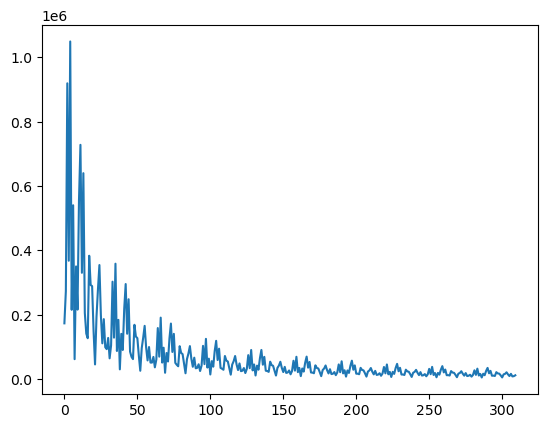

In [45]:
plt.plot(losses)

In [50]:
@functools.partial(jax.jit, static_argnames=("num_steps",))
def langevin_sampling(
    params: chex.ArrayTree,
    key: chex.PRNGKey,
    step_size: float,
    initial_samples: jax.Array,
    num_steps: int,
) -> jax.Array:

    def scan_fn(carry, _):
        states, key = carry
        key, sk = jax.random.split(key)
        noise = jax.random.normal(sk, shape=states.shape)
        next_states = states + step_size * vae_model.apply(params, states) + jnp.sqrt(2 * step_size) * noise
        return (next_states, key), None

    states = initial_samples
    (states, _), _ = jax.lax.scan(scan_fn, (states, key), jnp.arange(num_steps))
    return states

In [58]:
# 定义潜在空间的维度和采样数量
latent_dim = vae_model.bottleneck
num_samples = 2000

# 生成随机的潜在变量
key = jax.random.PRNGKey(0)  # 确保重现性
z = jax.random.normal(key, (num_samples, latent_dim))

# 使用解码器生成数据
decoded_samples = vae_model.apply(params, z, method=Decoder)


TypeError: __init__() takes 2 positional arguments but 3 were given

In [56]:
# 设置采样参数
num_samples = 100  # 初始样本数
latent_dim = params['params']['encoder']['Dense_0']['kernel'].shape[1]  # 假设潜变量的维度与模型输入匹配
print(latent_dim)
step_size = 0.01  # 采样步长
num_steps = 100  # 采样步骤数

# 生成随机的初始样本
key = jax.random.PRNGKey(0)
initial_samples = jax.random.normal(key, (num_samples, 2))

# 执行采样
sampled_states = langevin_sampling(params, key, step_size, initial_samples, num_steps)


5


TypeError: unsupported operand type(s) for *: 'DynamicJaxprTracer' and 'tuple'

In [38]:
vae = VAE(bottleneck=2, out=64)
params = vae.init(random.PRNGKey(10), X_train)
vae.apply(params, X_train, random.PRNGKey(10))[0][0].reshape(8, 8)

vae_e = VAE_Encoder(2)
mu, log_sigma = vae_e.apply({"params": params["params"]["encoder"]}, X_train)

tfd = tfp.distributions
tfd.kl_divergence(q, p).shape

Array([-3.2532732 ,  1.1896174 , -3.4545043 ,  2.3267832 , -2.4385881 ,
       -0.46924445,  1.4601564 ,  2.8878324 , -2.1490464 ,  0.32782367,
       -0.777697  , -0.63151634,  2.7094953 , -1.3484472 , -0.58958846,
        1.1598113 , -2.853172  , -0.10329672,  2.183104  ,  1.9617633 ,
       -0.9053487 ,  1.1528884 , -0.8928656 , -0.427122  , -0.7217131 ,
        3.013794  , -1.5115805 ,  2.8303847 , -0.76462805,  0.14255452,
        1.0155694 , -0.71498173,  1.5915252 , -1.7190071 ,  2.3187704 ,
       -1.0809392 , -0.7904027 ,  0.54775524, -3.1673207 , -0.31120998,
       -2.6969333 , -0.29203022, -0.81733847, -0.15960121, -0.7187393 ,
        0.4065514 ,  3.1541066 ,  0.44196793, -0.44904703, -1.8769628 ,
        0.30409533, -1.164591  , -1.8494718 , -3.9176226 ,  0.30354655,
        1.8866005 ,  0.39930943, -2.4357493 ,  2.0350595 , -2.2439299 ,
        0.66853964, -1.8067607 , -1.0316894 ,  2.6057978 ], dtype=float32)